# testing

### imports

In [2]:
from scipy import io
import numpy as np
import matplotlib.pyplot as plt
import statistics

# https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.lombscargle.html
import scipy.signal as signal

# interpolation because ARDUINO data is spaced unevenly
import scipy.interpolate as interpolate

# save data
import pickle

### load `data` from .mat file and split into `params` and `response`

In [3]:
mat_dict = io.loadmat('./Chandler/Phase1/ToneDisc_ANChandler_p1_d1.mat')

data = mat_dict['data'][0][0]
params = data[0][0][0]
response = data[1][0][0]

### get `dataArduino` (ARDUINO data) and `respMTX` (trials) from response, `get MTXTrialType` from params

In [4]:
dataArduino = response[0]
print("dataArduino shape: "+str(dataArduino.shape))
respMTX = response[2]
print("respMTX shape: "+str(respMTX.shape))

MTXTrialType = params[16]
print("MTXTrialType shape: "+str(MTXTrialType.shape))

num_trials = respMTX.shape[0]
print("number of trials: "+str(num_trials))

dataArduino shape: (229399, 7)
respMTX shape: (112, 7)
MTXTrialType shape: (1000, 5)
number of trials: 112


preview trials

In [5]:
print(respMTX[0])
print(respMTX[1])

[ 3.4869413  4.2348613  1.         7.5072248 -2.4108     0.
  1.       ]
[13.8300967        nan        nan 14.4539724 -2.401      1.
        nan]


In [6]:
np.set_printoptions(suppress = True,
   formatter = {'float_kind':'{:f}'.format})
print(respMTX)

[[3.486941 4.234861 1.000000 7.507225 -2.410800 0.000000 1.000000]
 [13.830097 nan nan 14.453972 -2.401000 1.000000 nan]
 [16.745678 17.452063 1.000000 18.663083 -2.494100 0.000000 1.000000]
 [25.572283 nan nan 26.503163 -2.249100 1.000000 nan]
 [28.196570 28.755291 1.000000 29.657218 -2.288300 0.000000 1.000000]
 [36.221121 36.880009 1.000000 40.963986 -2.386300 0.000000 1.000000]
 [55.213248 nan nan 55.421869 -2.454900 1.000000 nan]
 [60.990274 61.675817 1.000000 66.495173 -2.396100 0.000000 1.000000]
 [71.448605 71.974415 1.000000 72.635005 -2.376500 0.000000 1.000000]
 [76.978006 77.786194 1.000000 80.266626 -2.337300 0.000000 1.000000]
 [89.646523 nan nan 90.081210 -2.307900 1.000000 nan]
 [94.266099 94.737816 1.000000 94.932197 -2.435300 0.000000 1.000000]
 [101.367526 101.745299 1.000000 102.004583 -2.538200 0.000000 1.000000]
 [118.090317 119.025996 1.000000 126.861631 -2.503900 0.000000 1.000000]
 [131.004954 nan nan 131.452035 -2.533300 1.000000 nan]
 [134.282260 134.937356 1

### Look at an individual trial specific data `trail_respMTX`, `trial_dataArduino`, and `trial_MTXTrialType`. Plot 5s of the trial

(0.0, 2.0)

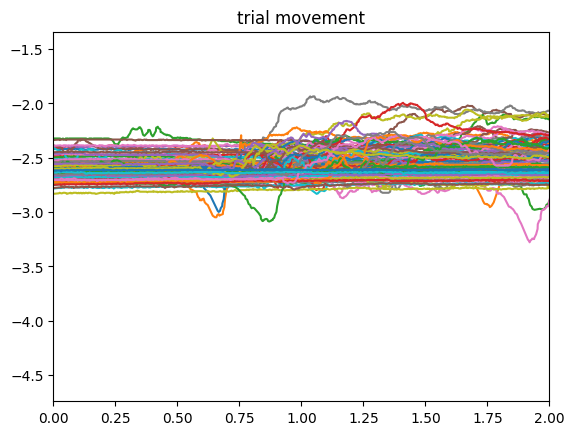

In [21]:
for trial_i in range(0, num_trials):
    trial_respMTX = respMTX[trial_i]

    if trial_respMTX[-1] == 1:

        start_t = respMTX[trial_i][0]
        for arduino_i, arduino_t in enumerate(dataArduino[:, 0]):
            if start_t <= arduino_t:
                start_arduino_i = arduino_i
                break

        if trial_i < num_trials - 1:
            end_t = respMTX[trial_i+1][0]
            for arduino_i, arduino_t in enumerate(dataArduino[:, 0]):
                if end_t <= arduino_t:
                    end_arduino_i = arduino_i
                    break
        else:
            end_arduino_i = len(dataArduino) - 1


        trial_dataArduino = dataArduino[start_arduino_i:end_arduino_i,:]
        trial_MTXTrialType = MTXTrialType[trial_i, :]

        # plot lever movement across trial
        plt.plot(trial_dataArduino[:, 0] - trial_dataArduino[0, 0], trial_dataArduino[:, 1])
plt.title("trial movement")
plt.xlim([0,2])

### Look at sampling rate

In [151]:
dts = []
old_arduino_t = dataArduino[start_arduino_i, 0]
for arduino_t in dataArduino[start_arduino_i+1:end_arduino_i, 0]:
    dts.append(arduino_t - old_arduino_t)
    old_arduino_t = arduino_t

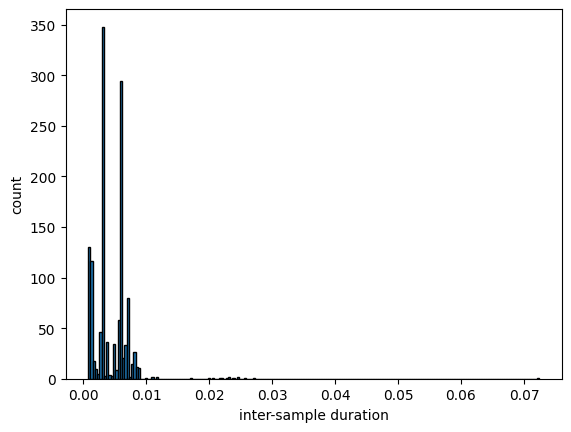

mean: 0.0044238993993994
std: 0.0034103880990198642


In [152]:
# plotting histogram of dataArduino inter-sample durations
plt.hist(dts, bins=200, edgecolor='black')
plt.xlabel('inter-sample duration')
plt.ylabel('count')
plt.show()

# print out mean and std
print("mean: " + str(sum(dts) / len(dts)))
print("std: " + str(statistics.stdev(dts)))

In [168]:
1/(0.0044238993993994+ (3*0.0034103880990198642))

68.23580031532879

### spline interpolation
for unevenly spaced data

In [99]:
new_fs = 1000
f = interpolate.interp1d(trial_dataArduino[:, 0], trial_dataArduino[:, 1], kind='slinear')
interpol_start_t = int(np.ceil(min(trial_dataArduino[:,0])))
interpol_end_t = int(np.floor(max(trial_dataArduino[:,0])))
num_samples = new_fs*(interpol_end_t-interpol_start_t)
newx = np.linspace(interpol_start_t, interpol_end_t, num_samples)
newy = f(newx)

In [103]:
print("avg original freq in trial: "+str(1/0.005))
print("new interpolated freq: "+str(num_samples/(interpol_end_t - interpol_start_t)))

avg original freq in trial: 200.0
new interpolated freq: 1000.0


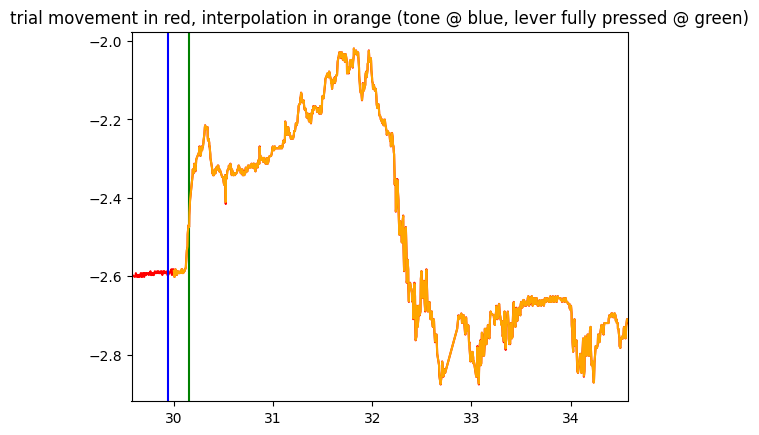

In [104]:
# plot lever movement and interpolation across trial
plt.plot(trial_dataArduino[:, 0], trial_dataArduino[:, 1], 'red')
plt.axvline(x = trial_respMTX[1], color = 'b')
plt.title("trial movement in red, interpolation in orange (tone @ blue, lever fully pressed @ green)")
plt.axvline(x = trial_respMTX[3], color = 'g')
plt.xlim((start_t, start_t+5))
plt.plot(newx, newy, 'orange')
plt.show()
